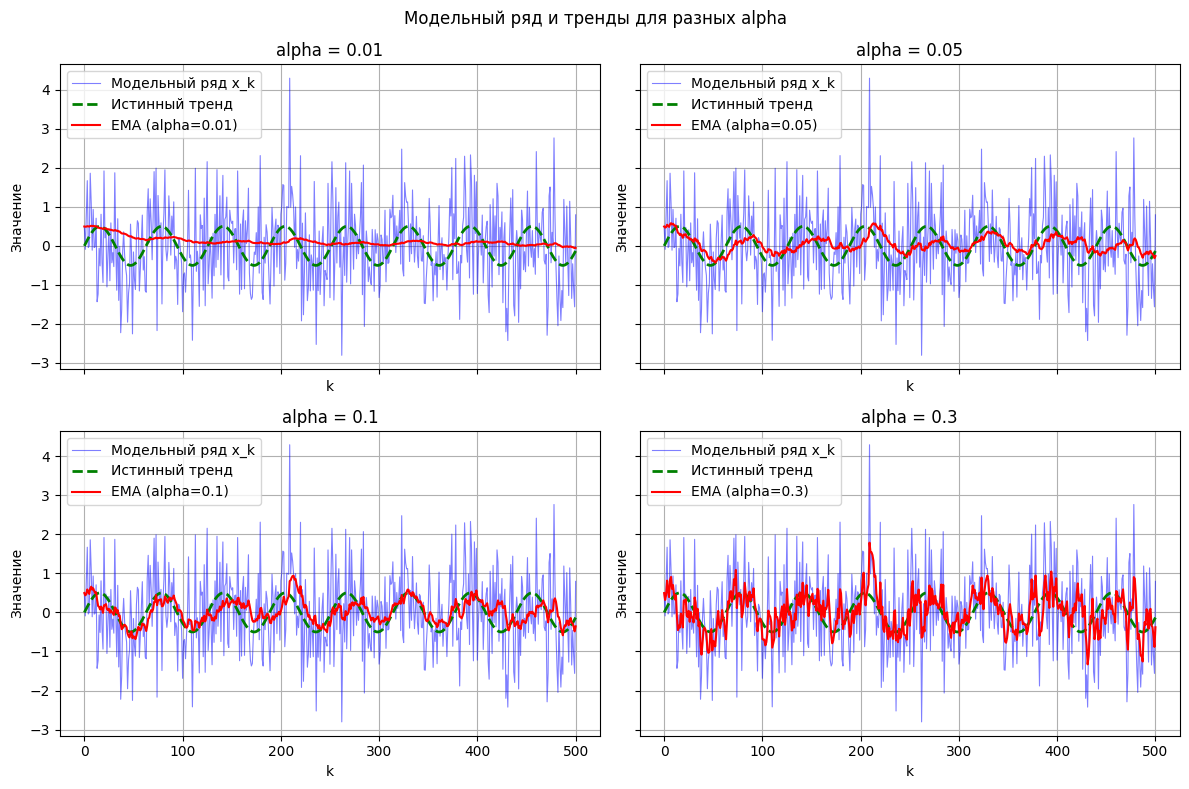

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, shapiro, chisquare, norm, normaltest

k = np.arange(0, 501)
h = 0.1
true_trend = 0.5 * np.sin(k * h)
np.random.seed(42)
noise = np.random.normal(0, 1, size=len(k))
x = true_trend + noise

# 2. Extract trend using EMA with alpha = 0.01, 0.05, 0.1, 0.3
alphas = [0.01, 0.05, 0.1, 0.3]
ema_trends = {}


def exponential_moving_average(series, alpha):
	ema = np.zeros(len(series))
	ema[0] = series[0]  # Initial value y1 = x1
	for i in range(1, len(series)):
		ema[i] = alpha * series[i] + (1 - alpha) * ema[i - 1]
	return ema

# Вычисление EMA для всех alpha
for alpha in alphas:
	ema_trends[alpha] = exponential_moving_average(x, alpha)

# Построение 4 графиков в одном окне (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
fig.suptitle('Модельный ряд и тренды для разных alpha')

for idx, alpha in enumerate(alphas):
    ax = axes[idx // 2, idx % 2]
    ax.plot(k, x, 'b-', alpha=0.5, label='Модельный ряд x_k', linewidth=0.8)
    ax.plot(k, true_trend, 'g--', label='Истинный тренд', linewidth=2)
    ax.plot(k, ema_trends[alpha], 'r-', label=f'EMA (alpha={alpha})', linewidth=1.5)
    ax.set_title(f'alpha = {alpha}')
    ax.set_xlabel('k')
    ax.set_ylabel('Значение')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [2]:
# Вычисление MSE для каждого alpha
mse_results = {}
for alpha in alphas:
    mse = np.mean((ema_trends[alpha] - true_trend)**2)
    mse_results[alpha] = mse


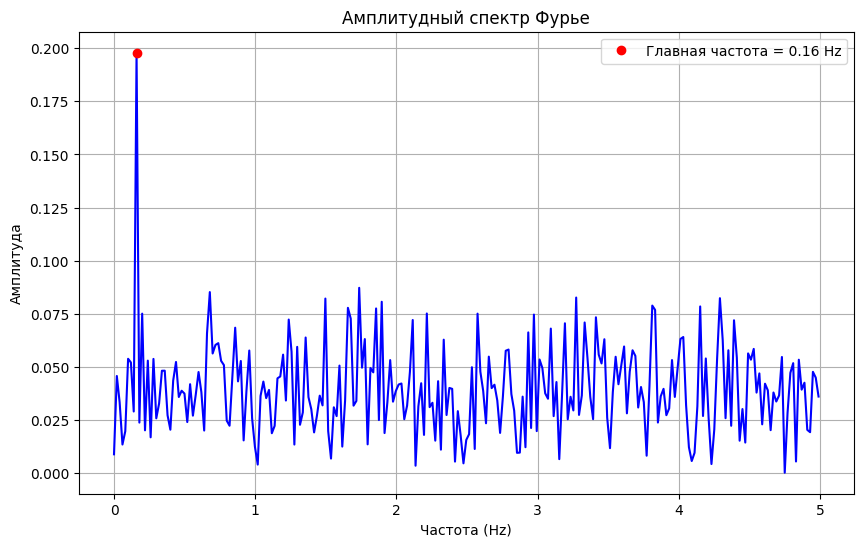

Главная частота: 0.16 Hz с амплитудой 0.1979


In [3]:
# Вычисление амплитудного спектра Фурье
n = len(x)
x_fft = np.fft.fft(x)  # Быстрое преобразование Фурье
amplitude_spectrum = np.abs(x_fft) / n  # Амплитудный спектр (нормированный)
frequencies = np.fft.fftfreq(n, d=h)  # Частоты

# Учитываем только положительные частоты (половина спектра)
positive_freq_mask = frequencies >= 0
amplitude_spectrum = amplitude_spectrum[positive_freq_mask]
frequencies = frequencies[positive_freq_mask]

# Определение главной частоты (максимум амплитуды, исключая нулевую частоту)
main_freq_idx = np.argmax(amplitude_spectrum[1:]) + 1  # Исключаем нулевую частоту
main_frequency = frequencies[main_freq_idx]
main_amplitude = amplitude_spectrum[main_freq_idx]

# Построение графика амплитудного спектра
plt.figure(figsize=(10, 6))
plt.plot(frequencies, amplitude_spectrum, 'b-')
plt.plot(main_frequency, main_amplitude, 'ro', label=f'Главная частота = {main_frequency:.2f} Hz')
plt.title('Амплитудный спектр Фурье')
plt.xlabel('Частота (Hz)')
plt.ylabel('Амплитуда')
plt.grid(True)
plt.legend()
plt.show()

print(f"Главная частота: {main_frequency:.2f} Hz с амплитудой {main_amplitude:.4f}")

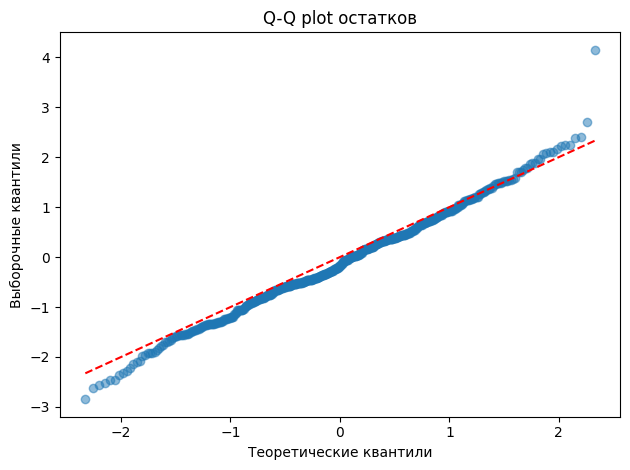

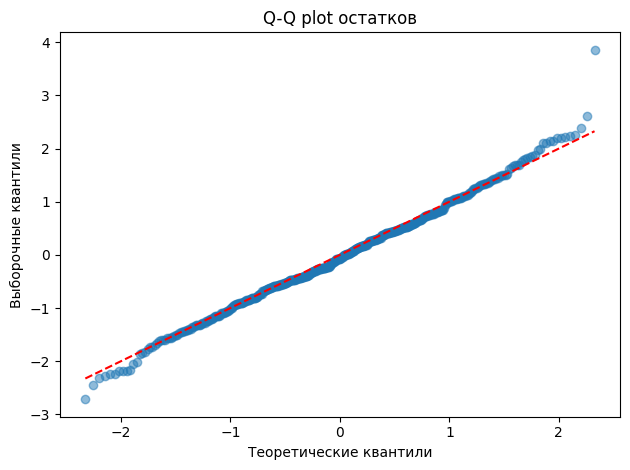

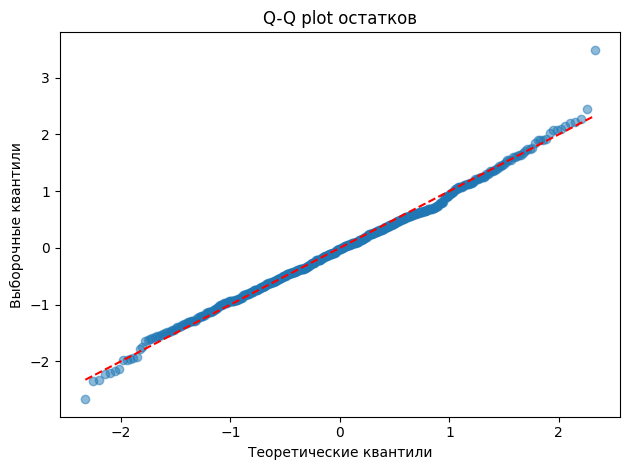

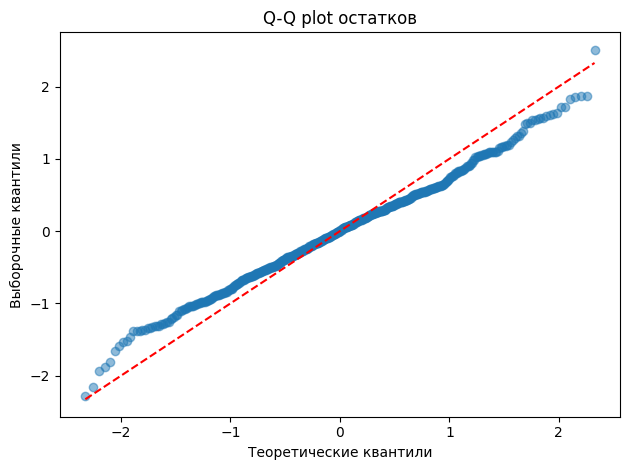

In [4]:
# 5. Subtract trends, check residuals
n = len(x)
results = {}


# Функция для подсчёта числа поворотных точек (p)
def count_turning_points(residuals):
	n = len(residuals)
	if n < 3:
		return 0
	p = 0
	for i in range(1, n - 1):
		if (residuals[i - 1] < residuals[i] > residuals[i + 1]) or (residuals[i - 1] > residuals[i] < residuals[i + 1]):
			p += 1
	return p


# Ожидаемое E(p) и Var(p)
def expected_var_turning_points(n):
	ep = (2 / 3) * (n - 2)
	var_p = (16 * n - 29) / 90
	return ep, var_p


def check_normality(residuals):
    """Проверка нормальности остатков несколькими методами"""
    results = {}
    
    # Тест Шапиро-Уилка (для n < 5000)
    if len(residuals) <= 5000:
        stat, p_value = shapiro(residuals)
        results['shapiro'] = {'stat': stat, 'p_value': p_value, 'normal': p_value > 0.05}
    
    
    # Q-Q plot
    residuals_sorted = np.sort(residuals)
    theoretical_quantiles = norm.ppf(np.linspace(0.01, 0.99, len(residuals)))
    plt.scatter(theoretical_quantiles, residuals_sorted, alpha=0.5)
    plt.plot([theoretical_quantiles[0], theoretical_quantiles[-1]], 
             [theoretical_quantiles[0], theoretical_quantiles[-1]], 'r--')
    plt.title(f'Q-Q plot остатков')
    plt.xlabel('Теоретические квантили')
    plt.ylabel('Выборочные квантили')
    
    plt.tight_layout()
    plt.show()
    
    return results

# Анализ остатков для каждого alpha
n = len(x)
results = {}

for alpha in alphas:
    trend = ema_trends[alpha]
    residuals = x - trend
    
    # 5.1 Несмещенность среднего
    mean_res = np.mean(residuals)
    std_res = np.std(residuals)
    unbiased = abs(mean_res) < 0.05  # Порог для "близко к нулю"
	
    
    # 5.2 Случайность (поворотные точки)
    p = count_turning_points(residuals)
    ep, var_p = expected_var_turning_points(n)
    std_p = np.sqrt(var_p)
    z_p = (p - ep) / std_p
    random_tp = abs(z_p) < 1.96  # 95% уровень
    
    # 5.3 Случайность (коэффициент Кендалла)
    tau, p_value_tau = kendalltau(k, residuals)
    var_tau = 2 * (2 * n + 5) / (9 * n * (n - 1))
    std_tau = np.sqrt(var_tau)
    z_tau = tau / std_tau
    random_kendall = abs(z_tau) < 1.96
    
    # 5.4 Нормальность
    normality_results = check_normality(residuals)
    
    results[alpha] = {
        'residuals': residuals,
        'mean_res': mean_res,
        'std_res': std_res,
        'unbiased': unbiased,
        'p': p,
        'ep': ep,
        'z_p': z_p,
        'random_tp': random_tp,
        'tau': tau,
        'p_value_tau': p_value_tau,
        'z_tau': z_tau,
        'random_kendall': random_kendall,
        'normality': normality_results
    }

In [5]:
# Вывод результатов анализа остатков
print("\n5. Анализ остатков:")
for alpha, res in results.items():
    print(f"\nAlpha = {alpha}:")
    print(f"  Несмещенность: mean = {res['mean_res']:.4f} (σ = {res['std_res']:.4f}), {'✓' if res['unbiased'] else '✗'}")
    print(f"  Поворотные точки: p = {res['p']}, E(p) = {res['ep']:.1f}, z = {res['z_p']:.2f}, {'Случайны ✓' if res['random_tp'] else 'Не случайны ✗'}")
    print(f"  Кендалл tau: τ = {res['tau']:.4f}, p-value = {res['p_value_tau']:.4f}, {'Случайны ✓' if res['random_kendall'] else 'Не случайны ✗'}")
    
    print(f"  Нормальность:")
    for test_name, test_res in res['normality'].items():
        print(f"    {test_name}: stat = {test_res['stat']:.4f}, p = {test_res['p_value']:.4f}, {'Нормальны ✓' if test_res['normal'] else 'Не нормальны ✗'}")


5. Анализ остатков:

Alpha = 0.01:
  Несмещенность: mean = -0.1079 (σ = 1.0166), ✗
  Поворотные точки: p = 337, E(p) = 332.7, z = 0.46, Случайны ✓
  Кендалл tau: τ = 0.0509, p-value = 0.0885, Случайны ✓
  Нормальность:
    shapiro: stat = 0.9953, p = 0.1355, Нормальны ✓

Alpha = 0.05:
  Несмещенность: mean = -0.0287 (σ = 0.9739), ✓
  Поворотные точки: p = 335, E(p) = 332.7, z = 0.25, Случайны ✓
  Кендалл tau: τ = 0.0098, p-value = 0.7437, Случайны ✓
  Нормальность:
    shapiro: stat = 0.9963, p = 0.2956, Нормальны ✓

Alpha = 0.1:
  Несмещенность: mean = -0.0153 (σ = 0.9234), ✓
  Поворотные точки: p = 335, E(p) = 332.7, z = 0.25, Случайны ✓
  Кендалл tau: τ = 0.0017, p-value = 0.9544, Случайны ✓
  Нормальность:
    shapiro: stat = 0.9974, p = 0.6409, Нормальны ✓

Alpha = 0.3:
  Несмещенность: mean = -0.0041 (σ = 0.7492), ✓
  Поворотные точки: p = 339, E(p) = 332.7, z = 0.67, Случайны ✓
  Кендалл tau: τ = -0.0042, p-value = 0.8870, Случайны ✓
  Нормальность:
    shapiro: stat = 0.9980, 

In [6]:
# Выводы по качеству трендов
best_alpha_mse = min(mse_results, key=mse_results.get)
print(f"\n1. КАЧЕСТВО ВОССТАНОВЛЕНИЯ ТРЕНДА:")
print(f"   - Лучший alpha по MSE: {best_alpha_mse} (MSE = {mse_results[best_alpha_mse]:.4f})")
print(f"\n2. СПЕКТРАЛЬНЫЙ АНАЛИЗ:")
print(f"   - Обнаружена главная частота: {main_frequency:.4f} Hz")

print(f"\n3. КАЧЕСТВО ОСТАТКОВ:")
unbiased_count = sum(1 for res in results.values() if res['unbiased'])
random_tp_count = sum(1 for res in results.values() if res['random_tp'])
random_kendall_count = sum(1 for res in results.values() if res['random_kendall'])

print(f"   - Несмещенные остатки: {unbiased_count}/{len(alphas)}")
print(f"   - Случайные по точкам поворота: {random_tp_count}/{len(alphas)}")
print(f"   - Случайные по Кендаллу: {random_kendall_count}/{len(alphas)}")


1. КАЧЕСТВО ВОССТАНОВЛЕНИЯ ТРЕНДА:
   - Лучший alpha по MSE: 0.1 (MSE = 0.0863)

2. СПЕКТРАЛЬНЫЙ АНАЛИЗ:
   - Обнаружена главная частота: 0.1597 Hz

3. КАЧЕСТВО ОСТАТКОВ:
   - Несмещенные остатки: 3/4
   - Случайные по точкам поворота: 4/4
   - Случайные по Кендаллу: 4/4
